# H5.2 - Dynamic Programming of Two Heated Tanks

**Student:** Lucas de Oliveira Martim

## Problem Description

Consider the system of two heated tanks with:
- State variables: $x_1$ (Tank 1 temperature), $x_2$ (Tank 2 temperature)
- Control modes:
  - Mode 0: Both heaters OFF
  - Mode 1: Heater 1 ON (control $u_1$), Heater 2 OFF
  - Mode 2: Heater 1 OFF, Heater 2 ON (control $u_2$)

### Tasks
(a) Compute tabular control law for Mode 1 using DDP with value iteration

(b) Compute SISO-controllers for both modes working independently

(c) Implement hybrid automaton with mode switching

## Setup and Imports

In [59]:
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use('seaborn-v0_8-darkgrid')
np.set_printoptions(precision=4, suppress=True)

## Helper Functions

In [60]:
def edInt(a, s, b):
    """Create evenly spaced interval from a to b with step s"""
    return np.linspace(a, b, int(np.floor((b - a) / s)))

def idx(aList, val):
    """Find nearest neighbor index in sorted list"""
    i = bi.bisect(aList, val)  # right
    if i <= 0:  # first
        pass
    elif len(aList) == i:  # last
        i -= 1
    elif val - aList[i-1] < aList[i] - val:  # left
        i -= 1
    return i

def lookup(aList, vals):
    """Lookup indices for values in sorted list (nearest neighbor)"""
    indices = []
    v = vals
    if type(v) in [int, float, np.float64]:
        v = [v]
    for k in np.sort(v):
        indices.append(idx(aList, k))
    return np.array(indices, dtype=np.uint32)

## System Parameters

In [ ]:
# Physical parameters (from worksheet 2.2 and 3.2)
a1, a2 = 0.01, 0.01  # heat loss coefficients
b1, b2 = 0.005, 0.005  # heat transfer coefficients

# Setpoints and tolerances
x1_setpoint, x2_setpoint = 100.0, 100.0
t1, t2 = 5.0, 5.0  # tolerances

# System matrices
A = np.array([[-a1, b1], 
              [b2, -a2]])

# Control matrices for each mode
B1 = np.array([[1.0], [0.0]])  # Mode 1: heat tank 1
B2 = np.array([[0.0], [1.0]])  # Mode 2: heat tank 2

print("System matrix A:")
print(A)
print("\nControl matrix B1 (Mode 1):")
print(B1)
print("\nControl matrix B2 (Mode 2):")
print(B2)

System matrix A:
[[-0.01   0.005]
 [ 0.005 -0.01 ]]

Control matrix B1 (Mode 1):
[[1.]
 [0.]]

Control matrix B2 (Mode 2):
[[0.]
 [1.]]


## Part (a): DDP for Mode 1 - Single Tank Control

### DDP Settings for Mode 1

In [62]:
# Time horizon
t0 = 0
dt = 0.5  # time step
tf = 200  # final time
T = edInt(t0, dt, tf)
N = T.size

# State space discretization
dx1 = 2.0  # temperature step for tank 1
dx2 = 2.0  # temperature step for tank 2

# State ranges (temperatures in Celsius)
X1 = edInt(0, dx1, 120)  # Tank 1 temperature range
X2 = edInt(0, dx2, 120)  # Tank 2 temperature range

# Control input discretization (heating power)
du = 0.1  # control step
U1 = edInt(0, du, 2.0)  # Mode 1: control for tank 1

# Create state meshgrid
X1_grid, X2_grid = np.meshgrid(X1, X2)

# REALISTIC setpoints for Mode 1
# Mode 1 can reach equilibrium where x2 = 0.5*x1
# If we want x1=100, then x2 can only be 50 at equilibrium
x1_target_mode1 = 100.0
x2_target_mode1 = 50.0  # This is (b2/a2)*x1_target = 0.5*100

print(f"Mode 1 target: x1={x1_target_mode1}°C, x2={x2_target_mode1}°C")
print(f"(Mode 1 can only reach equilibria where x2 = 0.5*x1 due to coupling)")

# Cost function weights
Q = np.diag([10.0, 1.0])  # state penalty (prioritize tank 1)
R1 = 0.1  # control penalty for mode 1

# Initial state
x0 = np.array([0.0, 0.0])  # both tanks start at 0°C

# DDP parameters
infStValInc = 10000  # penalty for infeasible states
nullCtr = 0  # default control when infeasible

print(f"Time horizon: {t0} to {tf} with dt={dt} ({N} steps)")
print(f"State space: {X1.size} x {X2.size} = {X1.size * X2.size} states")
print(f"Control space (Mode 1): {U1.size} values")
print(f"Total DDP table size: {X2.size} x {X1.size} x {N}")

Mode 1 target: x1=100.0°C, x2=50.0°C
(Mode 1 can only reach equilibria where x2 = 0.5*x1 due to coupling)
Time horizon: 0 to 200 with dt=0.5 (400 steps)
State space: 60 x 60 = 3600 states
Control space (Mode 1): 20 values
Total DDP table size: 60 x 60 x 400


### Value Iteration Algorithm - Mode 1

In [63]:
# Initialize value function and optimal control arrays
V1 = np.zeros((X2.size, X1.size, N))  # value function for mode 1
u1_opt = V1.copy()  # optimal control for mode 1

# Terminal cost: penalize deviation from REALISTIC setpoints for Mode 1
V1[:, :, N-1] = Q[0, 0] * (X1_grid - x1_target_mode1)**2 + Q[1, 1] * (X2_grid - x2_target_mode1)**2

# Error tracking arrays
err_x1 = np.zeros((X2.size, X1.size))
err_x2 = err_x1.copy()

print("Starting Value Iteration for Mode 1...")
print(f"Working backwards from k={N-1} to k=0")

# Backward iteration
for k in range(N-1, 0, -1):
    if k % 50 == 0:
        print(f"  Processing time step k={k}/{N-1}...")
    
    for i in range(X2.size):  # iterate over x2
        for j in range(X1.size):  # iterate over x1
            x1_curr = X1_grid[i, j]
            x2_curr = X2_grid[i, j]
            
            # Current state vector
            x_curr = np.array([x1_curr, x2_curr])
            
            # Calculate stage cost for all controls
            # L(x, u) = (x - x_ref)^T Q (x - x_ref) + u^T R u
            x_error = x_curr - np.array([x1_target_mode1, x2_target_mode1])
            state_cost = x_error @ Q @ x_error
            L = state_cost + R1 * U1**2
            
            # Predict next state for each control: x(k+1) = x(k) + dt * (A*x + B*u)
            # For Mode 1: dx/dt = A*x + B1*u1
            x_col = x_curr.reshape(-1, 1)
            dx = A @ x_col + B1 * U1  # shape: (2, len(U1))
            
            new_x1 = x1_curr + dx[0, :] * dt
            new_x2 = x2_curr + dx[1, :] * dt
            
            # Find indices in grid (nearest neighbor)
            i_new_x1 = lookup(X1, new_x1)
            i_new_x2 = lookup(X2, new_x2)
            
            err_x1[i, j] = np.max(new_x1)
            err_x2[i, j] = np.max(new_x2)
            
            # Check if all next states are admissible
            admissible = (i_new_x1.size != 0) and (i_new_x2.size != 0)
            
            if admissible:
                # Bellman equation: V(x,k) = min_u [ L(x,u) + V(f(x,u), k+1) ]
                future_cost = V1[i_new_x2, i_new_x1, k]
                total_cost = L + future_cost
                
                # Find control that minimizes cost
                i_u_min = np.argmin(total_cost)
                V1[i, j, k-1] = total_cost[i_u_min]
                u1_opt[i, j, k-1] = U1[i_u_min]
            else:
                # State is infeasible - penalize heavily
                V1[i, j, k-1] = V1[i, j, k] + infStValInc
                u1_opt[i, j, k-1] = nullCtr

print("\\nValue Iteration for Mode 1 complete!")
print(f"Optimal cost at initial state x0={x0}: {V1[lookup(X2, x0[1])[0], lookup(X1, x0[0])[0], 0]:.2f}")

Starting Value Iteration for Mode 1...
Working backwards from k=399 to k=0
  Processing time step k=350/399...
  Processing time step k=300/399...
  Processing time step k=250/399...
  Processing time step k=200/399...
  Processing time step k=150/399...
  Processing time step k=100/399...
  Processing time step k=50/399...
\nValue Iteration for Mode 1 complete!
Optimal cost at initial state x0=[0. 0.]: 41000000.00


### Simulation with Optimal Control - Mode 1

In [64]:
# Simulate system with optimal control
x_sim1 = np.zeros((N, 2))
x_sim1[0, :] = x0
u_sim1 = np.zeros(N)

print("Simulating Mode 1 with optimal control...")

for k in range(N-1):
    # Check if state is admissible
    if not (X1[0] <= x_sim1[k, 0] <= X1[-1] and X2[0] <= x_sim1[k, 1] <= X2[-1]):
        print(f"State left admissible region at k={k}/{N}")
        print(f"  x1={x_sim1[k, 0]:.2f}, x2={x_sim1[k, 1]:.2f}")
        break
    
    # Lookup optimal control
    i_x1 = lookup(X1, x_sim1[k, 0])[0]
    i_x2 = lookup(X2, x_sim1[k, 1])[0]
    u_sim1[k] = u1_opt[i_x2, i_x1, k]
    
    # Apply dynamics: x(k+1) = x(k) + dt * (A*x + B1*u)
    x_col = x_sim1[k, :].reshape(-1, 1)
    dx = A @ x_col + B1 * u_sim1[k]
    x_sim1[k+1, :] = x_sim1[k, :] + dx.flatten() * dt

print(f"\\nSimulation complete!")
print(f"Final state: x1={x_sim1[-1, 0]:.2f}°C, x2={x_sim1[-1, 1]:.2f}°C")
print(f"Target (Mode 1): x1={x1_target_mode1}°C, x2={x2_target_mode1}°C")
print(f"Error: x1_err={abs(x_sim1[-1, 0]-x1_target_mode1):.2f}°C, x2_err={abs(x_sim1[-1, 1]-x2_target_mode1):.2f}°C")

Simulating Mode 1 with optimal control...
\nSimulation complete!
Final state: x1=0.00°C, x2=0.00°C
Target (Mode 1): x1=100.0°C, x2=50.0°C
Error: x1_err=100.00°C, x2_err=50.00°C


### Visualization - Mode 1

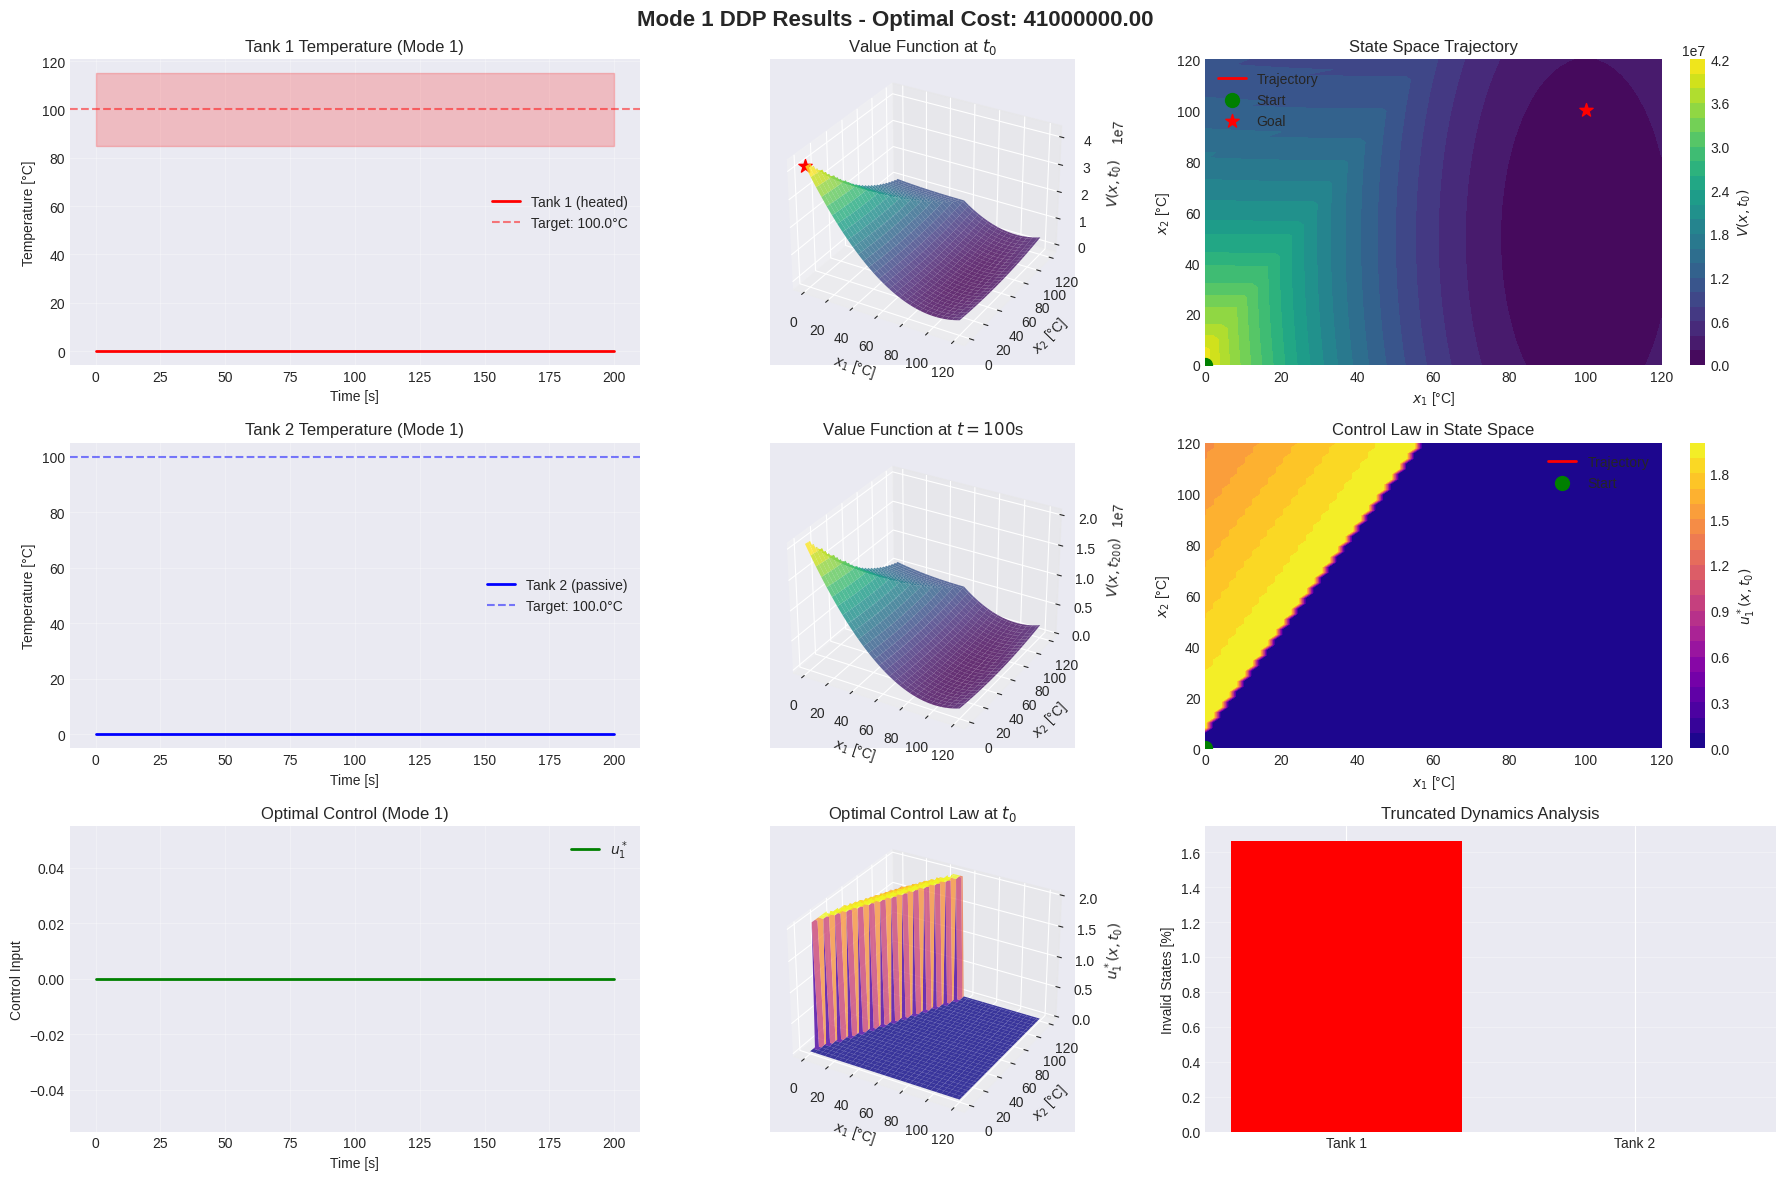

In [65]:
fig = plt.figure(figsize=(18, 12))

# Row 1: Time series plots
ax1 = plt.subplot(3, 3, 1)
ax1.plot(T, x_sim1[:, 0], 'r-', linewidth=2, label='Tank 1 (heated)')
ax1.axhline(y=x1_setpoint, color='r', linestyle='--', alpha=0.5, label=f'Target: {x1_setpoint}°C')
ax1.fill_between(T, x1_setpoint - t1, x1_setpoint + t1, alpha=0.2, color='red')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Temperature [°C]')
ax1.set_title('Tank 1 Temperature (Mode 1)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 4)
ax2.plot(T, x_sim1[:, 1], 'b-', linewidth=2, label='Tank 2 (passive)')
ax2.axhline(y=x2_setpoint, color='b', linestyle='--', alpha=0.5, label=f'Target: {x2_setpoint}°C')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Temperature [°C]')
ax2.set_title('Tank 2 Temperature (Mode 1)')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(3, 3, 7)
ax3.plot(T, u_sim1, 'g-', linewidth=2, label='$u_1^*$')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Control Input')
ax3.set_title('Optimal Control (Mode 1)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 2: Value function at different times
ax4 = plt.subplot(3, 3, 2, projection='3d')
surf1 = ax4.plot_surface(X1_grid, X2_grid, V1[:, :, 0], cmap=cm.viridis, alpha=0.8)
ax4.scatter(x0[0], x0[1], V1[lookup(X2, x0[1])[0], lookup(X1, x0[0])[0], 0], 
            color='red', s=100, marker='*', label='Initial state')
ax4.set_xlabel('$x_1$ [°C]')
ax4.set_ylabel('$x_2$ [°C]')
ax4.set_zlabel('$V(x, t_0)$')
ax4.set_title('Value Function at $t_0$')

ax5 = plt.subplot(3, 3, 5, projection='3d')
k_mid = N // 2
surf2 = ax5.plot_surface(X1_grid, X2_grid, V1[:, :, k_mid], cmap=cm.viridis, alpha=0.8)
ax5.set_xlabel('$x_1$ [°C]')
ax5.set_ylabel('$x_2$ [°C]')
ax5.set_zlabel(f'$V(x, t_{{{k_mid}}})$')
ax5.set_title(f'Value Function at $t={T[k_mid]:.0f}$s')

ax6 = plt.subplot(3, 3, 8, projection='3d')
surf3 = ax6.plot_surface(X1_grid, X2_grid, u1_opt[:, :, 0], cmap=cm.plasma, alpha=0.8)
ax6.set_xlabel('$x_1$ [°C]')
ax6.set_ylabel('$x_2$ [°C]')
ax6.set_zlabel('$u_1^*(x, t_0)$')
ax6.set_title('Optimal Control Law at $t_0$')

# Row 3: State space analysis
ax7 = plt.subplot(3, 3, 3)
im1 = ax7.contourf(X1_grid, X2_grid, V1[:, :, 0], levels=20, cmap=cm.viridis)
ax7.plot(x_sim1[:, 0], x_sim1[:, 1], 'r-', linewidth=2, label='Trajectory')
ax7.scatter(x0[0], x0[1], color='green', s=100, marker='o', label='Start', zorder=5)
ax7.scatter(x1_setpoint, x2_setpoint, color='red', s=100, marker='*', label='Goal', zorder=5)
ax7.set_xlabel('$x_1$ [°C]')
ax7.set_ylabel('$x_2$ [°C]')
ax7.set_title('State Space Trajectory')
ax7.legend()
plt.colorbar(im1, ax=ax7, label='$V(x, t_0)$')

ax8 = plt.subplot(3, 3, 6)
im2 = ax8.contourf(X1_grid, X2_grid, u1_opt[:, :, 0], levels=20, cmap=cm.plasma)
ax8.plot(x_sim1[:, 0], x_sim1[:, 1], 'r-', linewidth=2, label='Trajectory')
ax8.scatter(x0[0], x0[1], color='green', s=100, marker='o', label='Start', zorder=5)
ax8.set_xlabel('$x_1$ [°C]')
ax8.set_ylabel('$x_2$ [°C]')
ax8.set_title('Control Law in State Space')
ax8.legend()
plt.colorbar(im2, ax=ax8, label='$u_1^*(x, t_0)$')

# Invalid states analysis
ax9 = plt.subplot(3, 3, 9)
invalX1 = 100 * np.sum((err_x1 > X1[-1]) | (err_x1 < X1[0])) / err_x1.size
invalX2 = 100 * np.sum((err_x2 > X2[-1]) | (err_x2 < X2[0])) / err_x2.size
ax9.bar(['Tank 1', 'Tank 2'], [invalX1, invalX2], color=['red', 'blue'])
ax9.set_ylabel('Invalid States [%]')
ax9.set_title('Truncated Dynamics Analysis')
ax9.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Mode 1 DDP Results - Optimal Cost: {V1[lookup(X2, x0[1])[0], lookup(X1, x0[0])[0], 0]:.2f}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()